<a href="https://colab.research.google.com/github/comp-neural-circuits/plasticity-workshop/blob/dev/hebbian_plasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rate based Hebbian learning in action

In this part of the tutorial, we will generate orientation selectivity in a neuron, using different kinds of hebbian plasticity that you used in the first part of today's tutotrial. 

First we set up the rate based simulations and some functions to visualize the rates of neurons and synaptic weight evolution. 

In [ ]:
import sys, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm

In [ ]:
# utility functions

def setup_simulation(params):
    t = np.arange(0., params['t_sim'], params['dt'])
    rX = np.zeros((params['n0'], len(t)))
    rY = np.zeros((params['n1'], len(t)))
    wXY = np.zeros((params['n0']*params['n1'], len(t))) # later modify to store weights only sdt time steps
    return [t, rX, rY, wXY]   

In [ ]:
# Visualization of results functions

def show_rates(rX, rY, params, t1=0., t2=5000.):
    fig = plt.figure(figsize=[8,4])
    gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    id1, id2 = int(t1/params['dt']), int(t2/params['dt'])

    ax0 = fig.add_subplot(gs[0])
    im0 = ax0.imshow(rX[:,id1:id2], aspect='auto')
    ax0.set_title('Rate of Layer X')
    ax0.set_xlabel('Time (ms)')
    ax0.set_ylabel('Neuron id')
    plt.colorbar(im0, ax=ax0, label='Rate')

    ax1 = fig.add_subplot(gs[1])
    im1 = ax1.imshow(rY[:,id1:id2], aspect='auto')
    ax1.set_title('Rate of Layer Y')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Neuron id')
    plt.colorbar(im1, ax=ax1, label='Rate')

    fig.tight_layout()
    return

def show_weight_evolution(wXY, t, params):
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(t, wXY.T, '-')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Synaptic weights')
    return

def show_weights_at_time(wXY, params, t3=0.):
    fig = plt.figure()
    ax = plt.gca()
    id3 = int(t3/params['dt'])
    idn = 0 # which postsynaptic neuron 
    ax.plot(np.arange(params['n0']), wXY[:,id3].reshape((params['n0'], params['n1']))[:,idn], '.-')
    ax.set_xlabel('Orientation')
    ax.set_ylabel('Weight')
    ax.set_ylim([params['w_low'], params['w_high']])
    return 

In [ ]:
# Main simulation function

def run_simulation(params, delta_weights, input):

    input_times = input
    #[input_times, input_neurons] = input
    [t, rX, rY, wXY] = setup_simulation(params)
    
    # set initial weights
    wXY[:,0] = params['w_high']/2

    for _i, _t in enumerate(t):
        
        if _i == 0.:
          continue
        
        # state at time _t-1
        rx0, ry0 = rX[:,_i-1], rY[:,_i-1]
        wxy0 = wXY[:,_i-1]
        
        # specify input at this time and modify rx
        if _t in input_times:
          rx0[:] = 0.                           # remove the old input
          _n = np.random.choice(params['n0'])   # select which orientation input and/or neurons to activate
          rx0[_n] = params['input_amp']         # set the new input
        
        # update state to time _t
        rx1 = rx0
        ry1 = ry0 + (params['dt']/params['taum']) * (-ry0 + np.dot(wxy0.reshape(params['n1'], params['n0']), rx0))
        #wxy1 = update_weights(wxy0, rx1, ry1) 
        wxy1 = wxy0 + delta_weights(rx1, ry1)
        #wxy1 = rescale_weights(wxy1, params['w_low'], params['w_high'])

        # store
        rX[:,_i], rY[:,_i] = rx1, ry1
        wXY[:,_i] = wxy1
        
    return [t, rX, rY, wXY]

In [ ]:
# define parameters

params = {
    'n0' : 10,              # number of presynaptic neurons
    'n1' : 1,              # number of postsynaptic neurons
    'taum' : 10.,           # tau for rate equation (ms)
    'tauw' : 10000.,       # tau for synaptic weight equation (ms)
    't_sim' : 200000.,        # Time of simulation (ms)    
    'dt' : 0.1,             # Time step for simulation
    'sdt' : 100.,           # Time step for storing/recording weights
    'input_iei' : 100.,     # inter event interval for input events
    'input_amp' : 1.,        # Amplitude of input to first layer
    'w_low' : 0.,
    'w_high' : 1.
}

# Overview: Different plasticity rules


\begin{align}
ρ =& \; \text{presynaptic rate} \\
v =& \; \text{postsynaptic rate}
\end{align}

Simple Hebbian rule:
\begin{equation}
    \tau \dot{w} = \; v ρ
\end{equation}

If we want to do some analysis on the weight evolution, the simple hebbian rule becomes the correlation based rule:
\begin{equation}
    \tau \dot{w} = \; C w \\ 
    C = ⟨ \rho \rho^{T} ⟩
\end{equation}

\\

Threshold Hebbian rules:
\begin{align}
    \tau \dot{w} =& \; v (ρ - \theta) \\
    \tau \dot{w} =& \; (v - \theta) ρ \\
    \tau \dot{w} =& \; (v - \theta) (ρ - \theta)
\end{align}

The threshold Hebbian rule becomes the covariance based rule (threshold in pre and post, and we select the threshold to be $ ⟨v⟩$ or $ ⟨ρ⟩$):
\begin{equation}
    \tau \dot{w} = \; Q w \\ 
    Q = ⟨ (\rho - ⟨ρ⟩) (\rho - ⟨ρ⟩)^{T}⟩
\end{equation}

\\

Hebbian rule with Subtractive normalization:
\begin{equation}
    \tau \dot{w} = \; Cw - \frac{n^{T}Cw}{n^{T}n}n
\end{equation}

Hebbian rule with Mulitplicative normalization:
\begin{equation}
    \tau \dot{w} = \; Cw - \frac{n^{T}Cw}{n^{T}n}w
\end{equation}

\\

BCM rule:
\begin{align}
    \tau \dot{w} =& \; v(v-θ ) ρ \\
    \tau_{\theta} \dot{\theta}  =& - θ + \frac{\bar{v}^{2}}{\rho}
\end{align}


All the different rules: 
\begin{align}
    \tau \dot{w} =& \; v ρ \\
    \tau \dot{w} =& \; v (ρ - \theta) \\
    \tau \dot{w} =& \; (v - \theta) ρ \\
    \tau \dot{w} =& \; (v - \theta) (ρ - \theta)    \\
    \tau \dot{w} =& \; C w \\
    \tau \dot{w} =& \; Q w \\
    \tau \dot{w} =& \; Cw - \frac{n^{T}Cw}{n^{T}n}n  \\
    \tau \dot{w} =& \; Cw - \frac{n^{T}Cw}{n^{T}n}w  \\
    \tau \dot{w} =& \; v(v-θ ) ρ \\
    \tau_{\theta} \dot{\theta}  =& - θ + \frac{\bar{v}^{2}}{\rho} \\    
\end{align}


# Hebbian Plasticity and L-events

As you have seen until now, there are different types of hebbian plasticify learning rules that we can use. 

### Coding exercise 1:
Enter the expression for simple hebbian plasticity. 

In [72]:
# Simple Hebbian

def hebbian(r0, r1):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw = (params['dt']/params['tauw']) * np.dot(r1, r0)

    dw = dw.reshape(params['n1'], params['n0'])
    return dw

def hebbian_1synapse(r0, r1):
    dw = r1 * r0
    return dw

### Task 1:

Show dw as a function of presynaptic activity

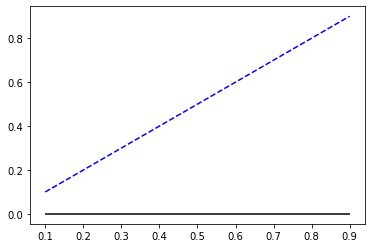

In [73]:
r1 = 1.
r0_range = np.arange(0.1, 1., 0.1)
dw_all = np.zeros(np.shape(r1_range))

for i,r0 in enumerate(r0_range):
    dw = hebbian_1synapse(r0, r1)
    dw_all[i] = dw

plt.plot(r0_range, dw_all, 'b--')
plt.hlines(0, r0_range[0], r0_range[-1], 'k', '-')
plt.show()

### Task 2:

Define L-event inputs 

In [ ]:
# input

def generate_regular_input_times(inter_event_interval, t_sim):
    return np.arange(0, t_sim, inter_event_interval)

# input: L-events

def generate_L_events_times(t_end, inter_event_interval):
    # generate sequence of L-event start times
    L_events_times = []
    _pt = 0. 
    while _pt < t_end:
        _pt += np.random.exponential(inter_event_interval)
        L_events_times.append(round(_pt, 1))
    return L_events_times

def define_L_event(n, amp_L, mean_dur, pct_low, pct_high):
    # for one L-event, specify the L-amp, L-neurons, L-dur
    amp = amp_L                                                             # amplitude
    dur = round(np.random.normal(mean_dur, mean_dur/10.), 1)                # duration
    pct = round(np.random.uniform(low=pct_low, high=pct_high), 2)           # participation ratio (20-60%)
    sN = np.random.choice(np.arange(n), 1)
    neur = np.roll(np.arange(n), -sN)[:int(pct*n)]                          # stimulated neurons
    return amp, dur, pct, neur

### Task 3: 

Run the simulation with simple Hebbian rule and L events. Do we get selectivity?

Task: To form Receptive Fields or Orientation selective neurons

Input: We give regular input, and at every starting of input time point, we randomly select an orientation to activate. 


Plasticity rule: Hebbian 

In [ ]:
# main

input_times = generate_regular_input_times(params['input_iei'], params['t_sim'])

[t, rX, rY, wXY] = run_simulation(params, hebbian, input_times)

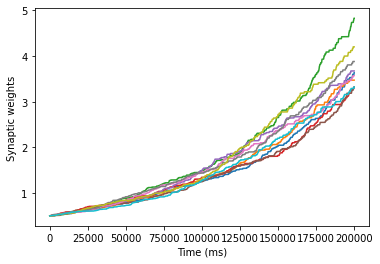

In [ ]:
# visualize output

#show_rates(rX, rY, params, t1=0., t2=5000.)
show_weight_evolution(wXY, t, params)
#show_weights_at_time(wXY, params, t3=0.)
#show_weights_at_time(wXY, params, t3=80000.)

# Hebbian plasticity with threshold

### Coding exercise 2:
Fill the equation

In [74]:
# Hebbian with threshold

def hebbian_threshold_1synapse(r0, r1, theta=params['theta']):
    dw = r1 * (r0 - theta)
    return dw

def hebbian_threshold(r0, r1, theta=params['theta']):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw = (params['dt']/params['tauw']) * np.dot(r1, r0 - theta)

    dw = dw.reshape(params['n1'], params['n0'])
    return dw

### Task 2.1:
show dw as a function of presynaptic activity

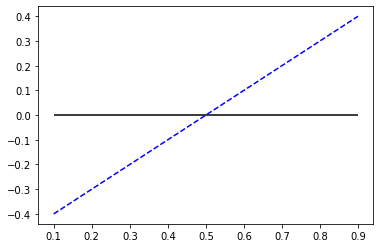

In [71]:
r1 = 1.
r0_range = np.arange(0.1, 1., 0.1)
dw_all = np.zeros(np.shape(r1_range))
params['theta'] = 0.5

for i,r0 in enumerate(r0_range):
    dw = hebbian_threshold_1synapse(r0, r1, params['theta'])
    dw_all[i] = dw

plt.plot(r0_range, dw_all, 'b--')
plt.hlines(0, r0_range[0], r0_range[-1], 'k', '-')
plt.show()

### Task 2.2

Run the network with this rule and see how the weights change

In [75]:
# main

params['theta'] = 0.5
[t, rX, rY, wXY] = run_simulation(params, hebbian_threshold, input_times)

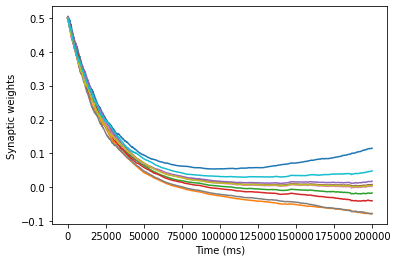

In [65]:
# visualize output

show_weight_evolution(wXY, t, params)

# Hebbian plasticity with subtractive normalization

Equation:

Here we cannot do for 1 synapse

### Coding exercise 3.0:
Fill the equation for subtractive normalization

In [80]:
# Hebbian with subtractive normalization

def hebbian_subtractive_normalization(r0, r1):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw1 = np.dot(r1, r0)              # simple Hebbian term
    dw2 = np.sum(dw1)/np.size(dw1)            # subtractive normalization term
    dw = (params['dt']/params['tauw']) * (dw1 - dw2)

    dw = dw.reshape(params['n1'], params['n0'])
    return dw

### Task 3.1:

### Task 3.2

Run the network with this rule and show the weight change

In [81]:
# main

[t, rX, rY, wXY] = run_simulation(params, hebbian_subtractive_normalization, input_times)

In [ ]:
# visualize output

show_weight_evolution(wXY, t, params)

In [ ]:
# Hebbian with multiplicative normalization

def hebbian_subtractive_normalization(r0, r1):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw1 = np.dot(r1, r0)                      # simple Hebbian term
    dw2 = np.sum(dw1)/np.size(dw1)            # subtractive normalization term
    dw = (params['dt']/params['tauw']) * (dw1 - dw2)

    dw = dw.reshape(params['n1'], params['n0'])
    return dw

In [ ]:
# main

[t, rX, rY, wXY] = run_simulation(params, hebbian_subtractive_normalization, input_times)

In [ ]:
# visualize output

show_weight_evolution(wXY, t, params)

# BCM rule

Show the equation here:

In [82]:
def bcm_1synapse(r0, r1, theta=params['theta']):
    dw = r1 * (r1 - theta) * r0
    return dw

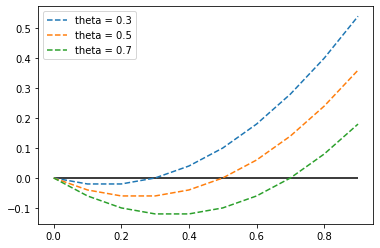

In [93]:
r0 = 1.
r1_range = np.arange(0.0, 1., 0.1)
dw_all = np.zeros(np.shape(r1_range))
#params['theta'] = 0.3

for theta in [0.3, 0.5, 0.7]:
    for i,r1 in enumerate(r1_range):
        dw = bcm_1synapse(r0, r1, theta)
        dw_all[i] = dw

    plt.plot(r1_range, dw_all, '--', label='theta = {}'.format(theta))

plt.hlines(0, r1_range[0], r1_range[-1], 'k', '-')
plt.legend()
plt.show()

In [ ]:
# plasticity functions

def update_weights_hebbian(w0, r0, r1, params):
    """
    r0 = rates of presynatic neurons   (n,1)
    r1 = rates of postsynaptic neurons (n,1)
    w0 = initial synaptic weights      (n,n)
    w1 = final synaptic weights        (n,n)
    """
    w1 = w0 + (params['dt']/params['tauw']) * np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0'])).reshape(-1)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

def update_weights_hebbian_subtractive_normalization(w0, r0, r1, params):
    Cw = np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0']))
    subtractive_part = np.sum(Cw)/np.size(Cw) 
    w1 = w0 + (params['dt']/params['tauw']) * (Cw.reshape(-1) - subtractive_part)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

def update_weights_hebbian_multiplicative_normalization(w0, r0, r1, params):
    w1 = w0 + (params['dt']/params['tauw']) * np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0'])).reshape(-1)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

def update_weights_BCM(w0):
    return w1

def rescale_weights(w, lower_bound, upper_bound):
    w[w < lower_bound] = lower_bound
    w[w > upper_bound] = upper_bound
    return w

def update_weights_hebbian(w0, r0, r1):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw = (params['dt']/params['tauw']) * np.dot(r1, r0)

    dw = dw.reshape(params['n0'], params['n1'])
    w1 = w0 + dw
    #w1 = rescale_weights(w1, params['w_low'], params['w_high'])  # restrict weight to upper and lower bounds
    return w1